# 第6章 化合物の構造生成

## 6. 1 逆解析

## 6. 2 SMILESの生成

### 6. 2. 1 LSTMを使った構造生成

rdkitのインストール

In [1]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 12.0 MB/s eta 0:00:00


モジュールのインポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
import sklearn
from tqdm.notebook import tqdm

In [3]:
import torch
print(torch.__version__)
from torch import nn

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

2.6.0+cu124
cuda:0


Google Driveのマウント

In [4]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/Cheminformatics")
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/Cheminformatics


学習用データの取り込み

In [5]:
df = pd.read_table("guacamol_v1_train.smiles", header=None)
df.columns = ["smi"]

print(df.shape)
df.head()

(1273104, 1)


,smi
0,CCC(C)(C)Br
1,CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...
2,Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1
3,CC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1
4,COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...


#### SMILESの取り出し

In [6]:
smiles = df["smi"].tolist()
smiles[:5]

['CCC(C)(C)Br',
 'CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O',
 'Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1',
 'CC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1',
 'COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O)OC)c2)cc(Cl)c1OC']

スタート文字（G）と終了文字（E）を配置

In [7]:
smiles = ["G"+smi+"E" for smi in smiles]
smiles[:5]

['GCCC(C)(C)BrE',
 'GCCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=OE',
 'GOc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1E',
 'GCC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1E',
 'GCOC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O)OC)c2)cc(Cl)c1OCE']

単語リストを作成

In [8]:
smiles_join = "".join(smiles)

unique_chars = list(set(smiles_join))
unique_chars = np.sort(unique_chars)
print(unique_chars)

['#' '%' '(' ')' '+' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'B'
 'C' 'E' 'F' 'G' 'H' 'I' 'N' 'O' 'P' 'S' '[' ']' 'b' 'c' 'e' 'i' 'l' 'n'
 'o' 'p' 'r' 's']


単語と番号を対応づける辞書を作成

In [9]:
# character to int
chr2int = dict((c, i) for i, c in enumerate(unique_chars))
print(chr2int)

{np.str_('#'): 0, np.str_('%'): 1, np.str_('('): 2, np.str_(')'): 3, np.str_('+'): 4, np.str_('-'): 5, np.str_('0'): 6, np.str_('1'): 7, np.str_('2'): 8, np.str_('3'): 9, np.str_('4'): 10, np.str_('5'): 11, np.str_('6'): 12, np.str_('7'): 13, np.str_('8'): 14, np.str_('9'): 15, np.str_('='): 16, np.str_('B'): 17, np.str_('C'): 18, np.str_('E'): 19, np.str_('F'): 20, np.str_('G'): 21, np.str_('H'): 22, np.str_('I'): 23, np.str_('N'): 24, np.str_('O'): 25, np.str_('P'): 26, np.str_('S'): 27, np.str_('['): 28, np.str_(']'): 29, np.str_('b'): 30, np.str_('c'): 31, np.str_('e'): 32, np.str_('i'): 33, np.str_('l'): 34, np.str_('n'): 35, np.str_('o'): 36, np.str_('p'): 37, np.str_('r'): 38, np.str_('s'): 39}


In [10]:
# int to character
int2chr = dict((i, c) for i, c in enumerate(unique_chars))
print(int2chr)

{0: np.str_('#'), 1: np.str_('%'), 2: np.str_('('), 3: np.str_(')'), 4: np.str_('+'), 5: np.str_('-'), 6: np.str_('0'), 7: np.str_('1'), 8: np.str_('2'), 9: np.str_('3'), 10: np.str_('4'), 11: np.str_('5'), 12: np.str_('6'), 13: np.str_('7'), 14: np.str_('8'), 15: np.str_('9'), 16: np.str_('='), 17: np.str_('B'), 18: np.str_('C'), 19: np.str_('E'), 20: np.str_('F'), 21: np.str_('G'), 22: np.str_('H'), 23: np.str_('I'), 24: np.str_('N'), 25: np.str_('O'), 26: np.str_('P'), 27: np.str_('S'), 28: np.str_('['), 29: np.str_(']'), 30: np.str_('b'), 31: np.str_('c'), 32: np.str_('e'), 33: np.str_('i'), 34: np.str_('l'), 35: np.str_('n'), 36: np.str_('o'), 37: np.str_('p'), 38: np.str_('r'), 39: np.str_('s')}


SMILESを数値化する

In [11]:
smiles_int = []

for i, smi in enumerate(smiles):
    smi_tmp = []
    for j, s in enumerate(smi):
        smi_tmp.append(chr2int[s])
    smiles_int.append(smi_tmp)

print(smiles[0])
print(smiles_int[0])

GCCC(C)(C)BrE
[21, 18, 18, 18, 2, 18, 3, 2, 18, 3, 17, 38, 19]


In [12]:
X = []
Y = []

for smi_int in smiles_int:
    X.append(torch.tensor(smi_int[:-1]))
    Y.append(torch.tensor(smi_int[1:]))

データをPyTorch用に変換

In [18]:
import torch.nn.utils.rnn as rnn

X_train = rnn.pad_sequence(X, batch_first=True, padding_value=chr2int["E"])
Y_train = rnn.pad_sequence(Y, batch_first=True, padding_value=chr2int["E"])

print(X[0])
print(X_train[0])

tensor([21, 18, 18, 18,  2, 18,  3,  2, 18,  3, 17, 38])
tensor([21, 18, 18, 18,  2, 18,  3,  2, 18,  3, 17, 38, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19])


In [19]:
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [20]:
# 検証用SMILESを読み込む
df_valid = pd.read_table("guacamol_v1_valid.smiles", header=None)
df_valid.columns = ["smi"]
smiles_valid = df_valid["smi"].tolist()

# スタート文字（G）と終了文字（E）を配置
smiles_valid = ["G"+smi+"E" for smi in smiles_valid]

# SMILESを数値化する
smiles_valid_int = []

for i, smi in enumerate(smiles_valid):
    smi_tmp = []
    for j, s in enumerate(smi):
        smi_tmp.append(chr2int[s])
    smiles_valid_int.append(smi_tmp)

# データをPytorch用に変換
X_valid = []
Y_valid = []

for smi_valid_int in smiles_valid_int:
    X_valid.append(torch.tensor(smi_valid_int[:-1]))
    Y_valid.append(torch.tensor(smi_valid_int[1:]))

X_valid = rnn.pad_sequence(X_valid, batch_first=True, padding_value=chr2int["E"])
Y_valid = rnn.pad_sequence(Y_valid, batch_first=True, padding_value=chr2int["E"])

valid_dataset = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

構造の作成

In [21]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.embd    = nn.Embedding(len(chr2int), 512)
        self.lstm    = nn.LSTM(512, 512, 3)
        self.dropout = nn.Dropout(0.5)
        self.linear  = nn.Linear(512, len(chr2int))

    def forward(self, x):
        x    = self.embd(x)
        x, _ = self.lstm(x)
        x    = self.dropout(x)
        x    = self.linear(x)
        return x

print(MyNet())

MyNet(
  (embd): Embedding(40, 512)
  (lstm): LSTM(512, 512, num_layers=3)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=512, out_features=40, bias=True)
)


In [ ]:
from torch import optim

model = MyNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
model.train()
model.to(device)

train_loss_list = []
valid_loss_list = []

train_loss = 0
train_size = 0
batch_idx = 1
n_epoch = 1

学習開始

In [22]:
for epoch in range(n_epoch):
    for train_inputs, train_targets in tqdm(train_loader, desc="Training"):
      optimizer.zero_grad()
      # 学習データで精度の評価
      train_outputs = model(train_inputs.to(device))
      each_train_loss = loss_fn(train_outputs.permute(0, 2, 1), train_targets.to(device))
      each_train_loss = each_train_loss.mean()
      train_loss += each_train_loss.item()
      train_size += len(train_inputs)
      each_train_loss.backward()
      optimizer.step()
      # 検証データで精度の評価
      if batch_idx % 100 == 0:
        train_loss_list.append((batch_idx, train_loss/train_size))
        train_loss = 0
        train_size = 0
        if batch_idx % 1000 == 0:
          valid_loss = 0
          with torch.no_grad():
            for valid_inputs, valid_targets in valid_loader:
              valid_outputs = model(valid_inputs.to(device))
              each_valid_loss = loss_fn(valid_outputs.permute(0, 2, 1), valid_targets.to(device))
              each_valid_loss = each_valid_loss.mean()
              valid_loss += each_valid_loss.item()
            valid_loss_list.append((batch_idx, valid_loss/len(valid_dataset)))
      batch_idx += 1

Training:   0%|          | 0/9947 [00:00<?, ?it/s]

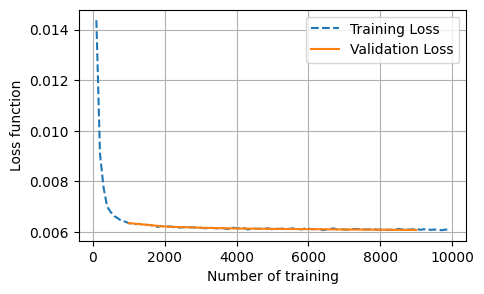

In [32]:
fig = plt.figure(figsize=(5, 3))

plt.plot(*list(zip(*train_loss_list)), label="Training Loss", linestyle="--")
plt.plot(*list(zip(*valid_loss_list)), label="Validation Loss")
plt.grid()
plt.xlabel("Number of training")
plt.ylabel("Loss function")
plt.legend()
plt.show()

モデルの評価

In [30]:
def comp_gen(max_len_smi=100):
  model.eval()
  gen_smiles = []

  start_tensor = torch.tensor(chr2int["G"], dtype=torch.int64).to(device)
  # LSTMに通して出力と新しい内部情報を得る
  x0 = start_tensor.unsqueeze(0)
  o = model(start_tensor.reshape(1, -1))
  out_dist = o[:, -1].view(-1).exp()
  top_i = torch.multinomial(out_dist, 1)[0]
  gen_smiles.append(top_i.item())

  # 生成された結果を次々とモデルに入力していく
  with torch.no_grad():
    for i in range(max_len_smi):
      inp = torch.tensor([[top_i]], dtype=torch.int64).to(device)
      o = model(inp)
      out_dist = o.view(-1).exp()
      top_i = torch.multinomial(out_dist, 1)[0]
      gen_smiles.append(top_i.item())

  generated_seq = "".join([int2chr[s] for s in gen_smiles])
  return generated_seq.replace("E", "")

In [31]:
for i in range(10):
  print(comp_gen(max_len_smi=100))

Cc1c2c2)NCCCc1
N
CCCC2cc(N(=N2ccccc(N=OCCC(C(C(=O)CC=O)c(=Occ24)cc2)C(=O)c(F)CC(CS(O)c1
O
O=C(-](C4c2c1CNS(C2c(SCN(-c4)C(=Oc(CC13cccc2
CC(CCC)c3C1)c3)c(F)c1NCC(ccc(=O)c2c(C(F)N(C)ccc1
CN(C(=O)CC(C=OC(C1c2ccc1C(CNC2
C(N4CC)CNC(S2c3)(C(=CCC1C1c3)c1c2cc1cc12c1
C(=CC(C(CCOC)c(F)CCc3c1CC2cn(=O)CO)(=O)ccc2cc3c(F)Nc(=O)CO)N3)c2S(O)C)CCCC(Cnnc(=O)COCCCN3cc3c3c(Nccc
CC)c1ccccc1c2c2c(O)(O)N(OC(CCC(N#CC


### 6. 2. 2 AEを使った構造生成

### 6. 2. 3 その他の構想生成

### 6. 2. 4 SELFIES：化合物の柔軟な表記方法